In the first cell, we define our query function. This is to be copied and pasted each time we want to query science windows. 

In [ ]:
import time

import astroquery.heasarc
from astropy.coordinates import SkyCoord
from astropy import units as u

Heasarc = astroquery.heasarc.Heasarc()

def get_scw_list(ra_obj, dec_obj,radius,start_date,end_date ):
    R = Heasarc.query_region(
            position = SkyCoord(ra_obj, dec_obj, unit='deg'),
            radius = f"{radius} deg",
            catalog = 'intscw', # 'mission' has been deprecated
            time = start_date + " .. " + end_date,
            good_isgri = ">1000",
        )
    # print(R)
    R.sort('scw_id') # changed SCW_ID to scw_id

    return R['scw_id'], R['scw_ver']  # changed SCW_VER to scw_ver


assert astroquery.__version__ >= '0.4.2.dev6611'
assert 'isdc' in astroquery.heasarc.Conf.server.cfgtype

In this second cell, define our source and region to query.

In [14]:
from astroquery.simbad import Simbad
from astropy import coordinates as coord

import json

import os
import shutil
import random

from astropy.io import fits

from scipy import stats

source_name = 'Crab'

result_table = Simbad.query_object(source_name)
source_coord = coord.SkyCoord(result_table['ra'][0], result_table['dec'][0], unit=("hourangle", "deg")) # changed RA and DEC to ra and dec respectively
ra=source_coord.ra.deg
dec=source_coord.dec.deg
radius=8.

Finally, define the time interval within which we wish to retrieve our object.

In [15]:
scwlist,version = get_scw_list(ra,dec, 10, '2020-01-01T00:00:00', '2020-06-01T00:00:00')

   scw_id    scw_ver scw_type  status ... obs_type pi_name data_size __row 
                                      ...                     byte         
------------ ------- -------- ------- ... -------- ------- --------- ------
026901160010     001 pointing  public ...                    2051072 299097
027000000012     001    other  public ...                     849920 299099
027000000020     001 pointing  public ...                    2483200 299100
149800020010     001 pointing  public ...                   14561280 301172
258100830031     001     slew  public ...                    1101824 301261
149800010021     001     slew  public ...                    2998272 301693
154400530021     001     slew  public ...                   20643840 301771
279500000041     001     slew private ...                    4399104 302049
074800260021     001     slew  public ...                   18846720 302098
149800010010     001 pointing  public ...                   12148736 302189
         ...

We then pick 10 science windows at random. 

In [16]:
nscw = 10
if len(scwlist) == 0:
    raise Exception('No science windows')

scw_pick = [(s+"."+v).strip() for s,v in zip(scwlist,version)]

if nscw >0 and len(scw_pick)>=nscw:
    random.seed(0)
    scw_pick = random.sample(scw_pick, nscw)
scw_pick = sorted(scw_pick)

print(scw_pick)

['021200630021.001', '074900350021.001', '110900000021.001', '154400530021.001', '155000270020.001', '155100280090.001', '155300030072.001', '176400540010.001', '182100530031.001', '231400550021.001']


Before moving on to using this query for our ODA, we need to input our token. 

In [9]:
token = ''

import getpass
token = getpass.getpass('Insert the token')

In [10]:
import oda_api.token
token = oda_api.token.discover_token()

In [12]:
oda_api.token.decode_oda_token(token)

{'sub': 'hucklethums@icloud.com',
 'email': 'hucklethums@icloud.com',
 'name': 'interstellxr',
 'roles': 'authenticated user, public-pool-hpc',
 'exp': 1741191208}

Now let us look at an example.

In [15]:
from oda_api.api import DispatcherAPI

disp = DispatcherAPI(url='https://www.astro.unige.ch/mmoda/dispatch-data')
par_dict = {'src_name': '4U 1700-377',
            'RA': '257.815417',
            'DEC': '-41.593417',
            'T1': '58195.455',
            'T2': '58195.555',
            'T_format': 'mjd',
            'instrument': 'spi_acs',
            'product_type': 'Real',
            'product': 'spi_acs_lc',
            'time_bin': '1',
            'user_catalog_file': None,
           'token': token}

data_collection = disp.get_product(**par_dict)
data_collection.show()

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/api.py:1069: UserWarning: 
----------------------------------------------------------------------------
the parameter: user_catalog_file   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T_format', 'T2', 'token', None, 'selected_catalog', 'data_level', 'time_bin', 'time_bin_format']
----------------------------------------------------------------------------

  warnings.warn(msg)


Please note that argument user_catalog_file is not used


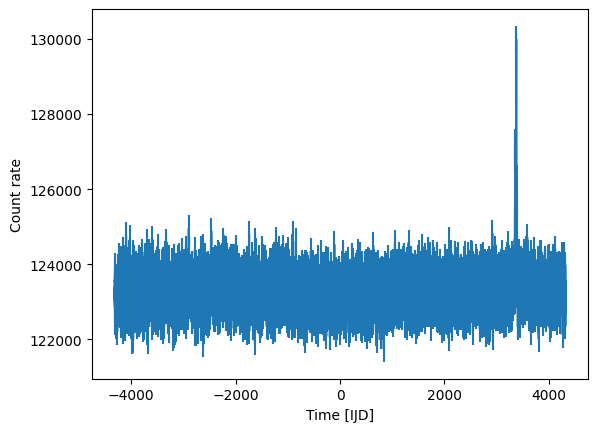

In [16]:
lc=data_collection._p_list[0]
import matplotlib.pyplot as plt

plt.errorbar(lc.data_unit[1].data['TIME'], lc.data_unit[1].data['RATE'], yerr=lc.data_unit[1].data['ERROR'])
plt.xlabel('Time [IJD]')
plt.ylabel('Count rate')

descr = disp.get_product_description(instrument='isgri',product_name='isgri_spectrum')